# Covid-19-Peak-Predictor-using-LSTM
1. Data Source from OUR WORLD in Data GitHub repository.
2. Goal to predict COVID-19 peak using Time Series Analysis
3. Dataset available here: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
from matplotlib import dates
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Javascript
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from google.colab import files
import os
import time
import getpass
import statistics
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from pylab import rcParams
import missingno as msno
!pip install geopandas #for map
import geopandas as gpd
from pandas import DataFrame
from pandas import to_datetime

import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 55)

#import sklearn packages
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import Holt

#Import keras Lib
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Bidirectional
from keras.layers.advanced_activations import LeakyReLU

# Use bokeh to plot predictions
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.models import NumeralTickFormatter

import plotly.express as px
import plotly.graph_objects as go

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 46.0 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 


In [2]:
#loading the URL
covid_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
#read the CSV file
cdata = pd.read_csv(covid_url, error_bad_lines=False)


In [3]:
#Number of columns
cdata.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
#Display all rows
pd.set_option('display.max_rows',None)

In [5]:
#Total rows
cdata.shape

(131039, 65)

In [6]:
#Checking for null values
cdata.isnull().sum()

iso_code                                        0
continent                                    8383
location                                        0
date                                            0
total_cases                                  7078
new_cases                                    7080
new_cases_smoothed                           8123
total_deaths                                18139
new_deaths                                  17943
new_deaths_smoothed                          8123
total_cases_per_million                      7715
new_cases_per_million                        7717
new_cases_smoothed_per_million               8755
total_deaths_per_million                    18763
new_deaths_per_million                      18567
new_deaths_smoothed_per_million              8755
reproduction_rate                           27538
icu_patients                               115412
icu_patients_per_million                   115412
hosp_patients                              112721


In [7]:
#Dropping unrequired columns
cdata.drop(['excess_mortality_cumulative_per_million','excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','human_development_index','hospital_beds_per_thousand','handwashing_facilities','male_smokers','female_smokers','gdp_per_capita','diabetes_prevalence','cardiovasc_death_rate','extreme_poverty','gdp_per_capita','population_density','reproduction_rate','continent',],axis=1, inplace= True)

In [8]:
cdata.head()

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
2,AFG,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
3,AFG,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
4,AFG,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


In [9]:
#Checking columns with 80% null values 
cdata.isnull().sum() >= (119656 * 0.80)

iso_code                                 False
location                                 False
date                                     False
total_cases                              False
new_cases                                False
new_cases_smoothed                       False
total_deaths                             False
new_deaths                               False
new_deaths_smoothed                      False
total_cases_per_million                  False
new_cases_per_million                    False
new_cases_smoothed_per_million           False
total_deaths_per_million                 False
new_deaths_per_million                   False
new_deaths_smoothed_per_million          False
icu_patients                              True
icu_patients_per_million                  True
hosp_patients                             True
hosp_patients_per_million                 True
weekly_icu_admissions                     True
weekly_icu_admissions_per_million         True
weekly_hosp_a

In [10]:
# dropping column with 80% null values
cdata.drop(['icu_patients','icu_patients_per_million','hosp_patients','hosp_patients_per_million','weekly_hosp_admissions','weekly_hosp_admissions_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million'],axis=1,inplace= True)

In [11]:
cdata.head(1)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


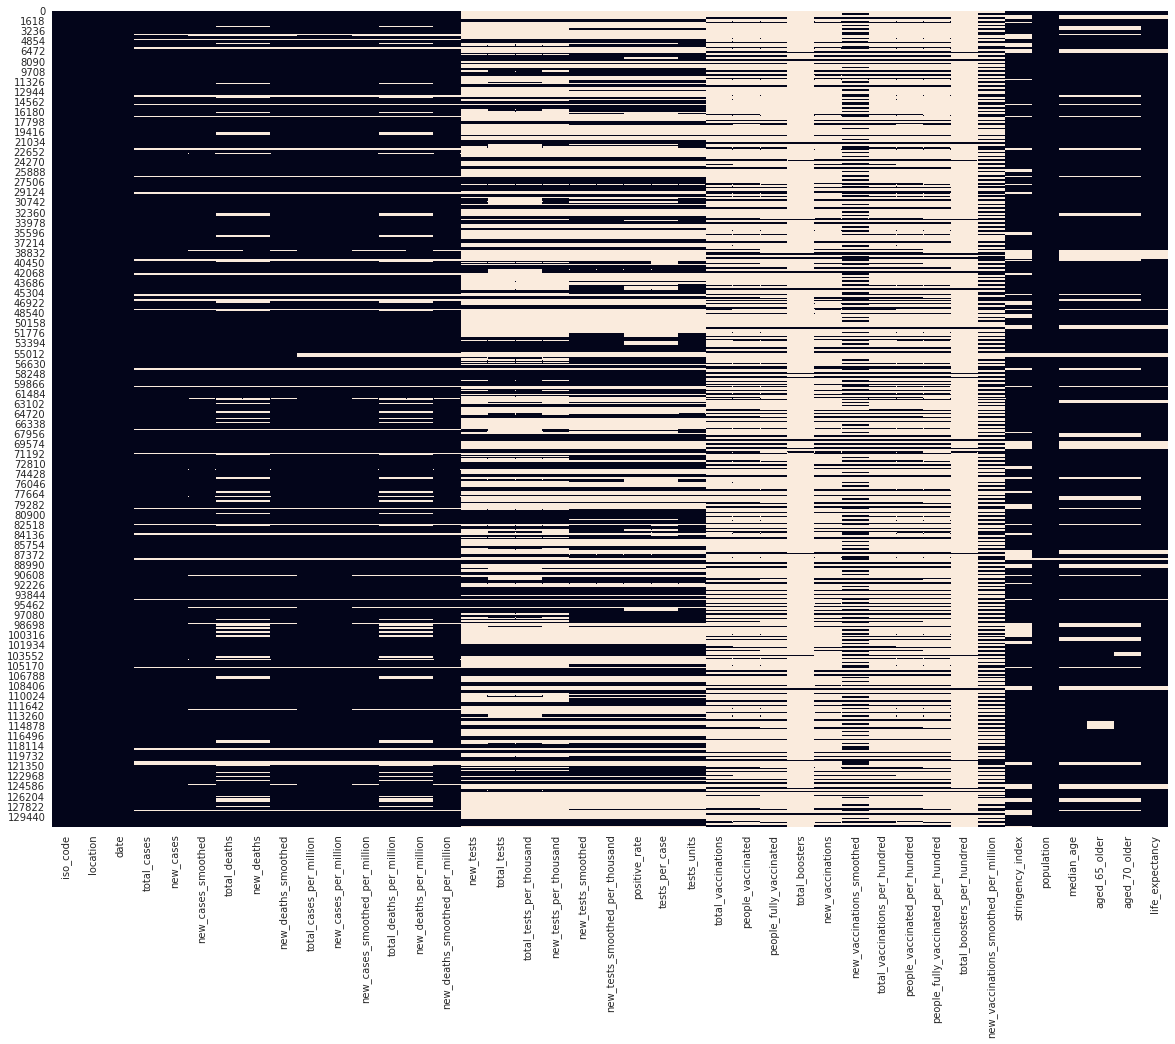

In [12]:
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [13]:
cdata.head(2)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


In [14]:
#Fill NaN values with 0
cdata.fillna(0,inplace=True)


In [15]:
cdata.head(2)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.0,0.0,0.126,0.126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83


In [16]:
cdata.isnull().sum()

iso_code                                 0
location                                 0
date                                     0
total_cases                              0
new_cases                                0
new_cases_smoothed                       0
total_deaths                             0
new_deaths                               0
new_deaths_smoothed                      0
total_cases_per_million                  0
new_cases_per_million                    0
new_cases_smoothed_per_million           0
total_deaths_per_million                 0
new_deaths_per_million                   0
new_deaths_smoothed_per_million          0
new_tests                                0
total_tests                              0
total_tests_per_thousand                 0
new_tests_per_thousand                   0
new_tests_smoothed                       0
new_tests_smoothed_per_thousand          0
positive_rate                            0
tests_per_case                           0
tests_units

In [17]:
cdata.head(10)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,0.000,0.0,0.0,0.0,0.126,0.126,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
2,AFG,Afghanistan,2020-02-26,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
3,AFG,Afghanistan,2020-02-27,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
4,AFG,Afghanistan,2020-02-28,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
5,AFG,Afghanistan,2020-02-29,5.0,0.0,0.714,0.0,0.0,0.0,0.126,0.000,0.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
6,AFG,Afghanistan,2020-03-01,5.0,0.0,0.714,0.0,0.0,0.0,0.126,0.000,0.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
7,AFG,Afghanistan,2020-03-02,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
8,AFG,Afghanistan,2020-03-03,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
9,AFG,Afghanistan,2020-03-04,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83


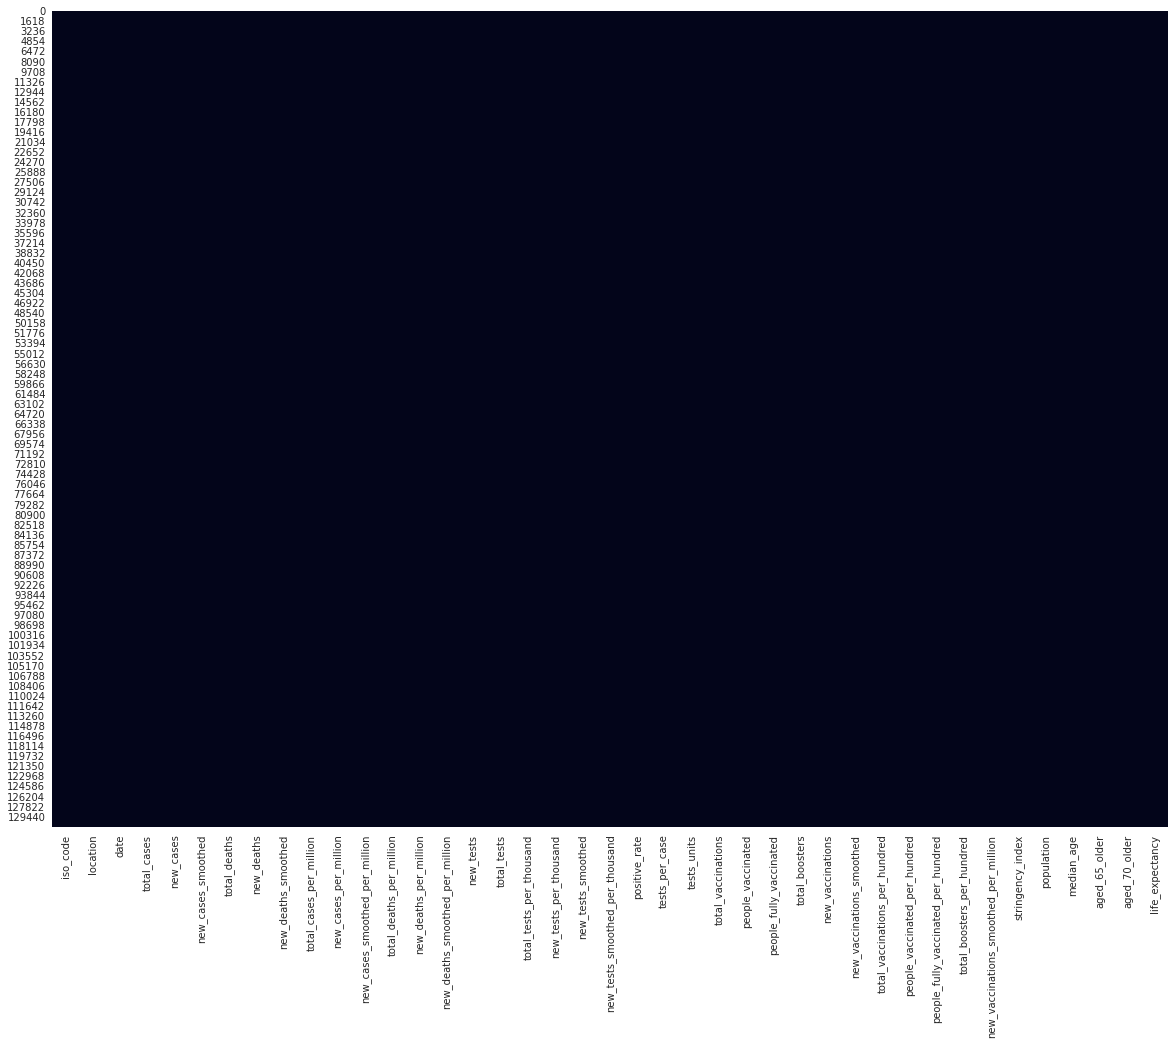

In [18]:
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [19]:
cdata['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

# LSTM Forecast

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



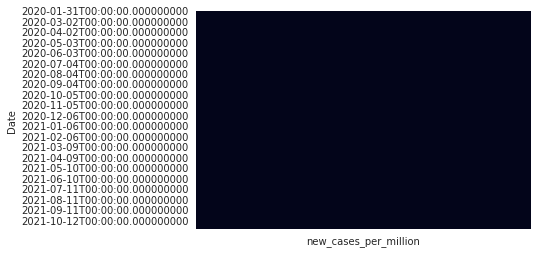

In [33]:
# Checking for stationary values
ndata = cdata
ndata.head(2)
ndata['Date'] = pd.to_datetime(ndata['date'])
df2 = ndata.copy()
df2.set_index('Date', inplace= True)
tdata = df2[df2['location'].isin(['Italy'])]
tdata.head(2)
tdata.dropna(inplace= True)
ndata2 = tdata[['new_cases_per_million']]
sns.heatmap(ndata2.isnull(), cbar=False)

In [34]:
ndata2.head(2)

,new_cases_per_million
Date,
2020-01-31,0.033
2020-02-01,0.000


In [35]:
ndata2.tail(2)

,new_cases_per_million
Date,
2021-11-03,85.940
2021-11-04,97.768


In [36]:
X = ndata2.values
X = X.reshape((-1,1))

In [37]:
split_percent = 0.7
split = int(split_percent*len(X))

X_train = X[:split]
X_test = X[split:]

date_train = ndata2.index[:split]
date_test = ndata2.index[split:]

In [38]:
look_back = 18
train_gen = TimeseriesGenerator(X_train, X_train, length= look_back, batch_size= 64)
test_gen = TimeseriesGenerator(X_test, X_test, length= look_back, batch_size= 64)
print(train_gen)
print(test_gen)

In [39]:
# set layers for LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(85, activation= 'relu', input_shape= (look_back, 1)))
#lstm_model.add(Dropout(0.05))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer= 'Adam', loss= 'mse')
num_epochs = 500
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 85)                29580     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 86        
Total params: 29,666
Trainable params: 29,666
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = lstm_model.fit(train_gen,epochs=num_epochs,verbose=2)
#print(history.history['loss'])
#print(history.history['accuracy'])

Epoch 1/500
7/7 - 1s - loss: 22418.1113
Epoch 2/500
7/7 - 0s - loss: 16533.8223
Epoch 3/500
7/7 - 0s - loss: 13774.6191
Epoch 4/500
7/7 - 0s - loss: 22650.1074
Epoch 5/500
7/7 - 0s - loss: 29120.1426
Epoch 6/500
7/7 - 0s - loss: 26825.9395
Epoch 7/500
7/7 - 0s - loss: 20201.0332
Epoch 8/500
7/7 - 0s - loss: 15271.7041
Epoch 9/500
7/7 - 0s - loss: 10272.5049
Epoch 10/500
7/7 - 0s - loss: 11589.0068
Epoch 11/500
7/7 - 0s - loss: 10854.6875
Epoch 12/500
7/7 - 0s - loss: 10719.0547
Epoch 13/500
7/7 - 0s - loss: 12382.9082
Epoch 14/500
7/7 - 0s - loss: 11897.8457
Epoch 15/500
7/7 - 0s - loss: 13201.7734
Epoch 16/500
7/7 - 0s - loss: 13451.9209
Epoch 17/500
7/7 - 0s - loss: 11834.4775
Epoch 18/500
7/7 - 0s - loss: 13246.3730
Epoch 19/500
7/7 - 0s - loss: 11108.3701
Epoch 20/500
7/7 - 0s - loss: 8687.7832
Epoch 21/500
7/7 - 0s - loss: 10035.5000
Epoch 22/500
7/7 - 0s - loss: 10100.5107
Epoch 23/500
7/7 - 0s - loss: 8442.4102
Epoch 24/500
7/7 - 0s - loss: 8091.4731
Epoch 25/500
7/7 - 0s - loss

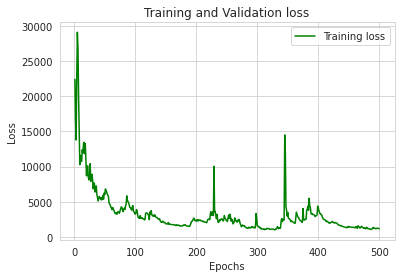

In [41]:
loss_train = history.history['loss']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
prediction = lstm_model.predict_generator(test_gen)
print(prediction.shape)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



(176, 1)


In [43]:
# plot data
# reshape to plot
X_train = X_train.reshape((-1))
X_test = X_test.reshape((-1))
prediction = prediction.reshape((-1))

# plot using plotly
trace1 = go.Scatter(
    x = date_train,
    y = X_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = X_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = 'LSTM Prediction',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'New_cases_per_million'}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [46]:
# functions to forecast model
X = X.reshape((-1))


def predict(num_prediction, model):
    prediction_list = X[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

# create future dates for x-axis    
def predict_dates(num_prediction):
    last_date = ndata2.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates
 
# num_prediction = number of days into future
num_prediction = 300
forecast = predict(num_prediction, lstm_model)
forecast_dates = predict_dates(num_prediction)

In [47]:
# plot data
trace1 = go.Scatter(
    x = ndata2.index,
    y = X,
    mode = 'lines',
    name = 'Original Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecasted Data'
)
layout = go.Layout(
    title = 'LSTM Forecast',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'new cases'}
)

fig = go.Figure(data=[trace1, trace2], layout=layout,)
fig.show()